In [32]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import language_tool_python

from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
    GPT2LMHeadModel,
    GPT2Tokenizer,
)

from evaluate import load
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from models.HeadlineGenerationModel import HeadlineGenerationModel
from models.NewsHeadlineDataModule import NewsHeadlineDataModule
from models.BartHeadlineGenerationModel import BartHeadlineGenerationModel

from evaluation.generate_headline import generate_headline
from evaluation.get_topn_words import get_topn_words
from evaluation.evaluate import calculate_scores_df_tuned, calculate_scores_df

In [2]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive

    drive.mount("/content/drive")
    PATH = "/content/drive/My Drive/UNI/sem6/NLP/project/articles_bbc.csv"
else:
    PATH = "data/articles_bbc.csv"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv(PATH, index_col=0)
df = data[['Article', 'Headline']]
print(df.shape)
data.head(10)

(2225, 2)


,Article,Headline,Summary
0,Quarterly profits at US media giant TimeWarner...,Ad sales boost Time Warner profit,TimeWarner said fourth quarter sales rose 2% t...
1,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuko...,Yukos unit buyer faces loan claim,Yukos' owner Menatep Group says it will ask Ro...
3,British Airways has blamed high fuel prices fo...,High fuel prices hit BA's profits,"Rod Eddington, BA's chief executive, said the ..."
4,Shares in UK drinks and food firm Allied Domec...,Pernod takeover talk lifts Domecq,Pernod has reduced the debt it took on to fund...
5,Japan's economy teetered on the brink of a tec...,Japan narrowly escapes recession,"On an annual basis, the data suggests annual g..."
6,The US created fewer jobs than expected in Jan...,Jobs growth still slow in the US,The job gains mean that President Bush can cel...
7,"India, which attends the G7 meeting of seven l...",India calls for fair trade rules,At a conference on developing enterprise hoste...
8,Ethiopia produced 14.27 million tonnes of crop...,Ethiopia's crop production up 24%,"In 2003, crop production totalled 11.49 millio..."
9,A US government claim accusing the country's b...,Court rejects $280bn tobacco case,A US government claim accusing the country's b...


In [5]:
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((1780, 2), (223, 2), (222, 2))

# T5-small model fine-tuning

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)

In [7]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["Article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["Headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'headline text token counts')

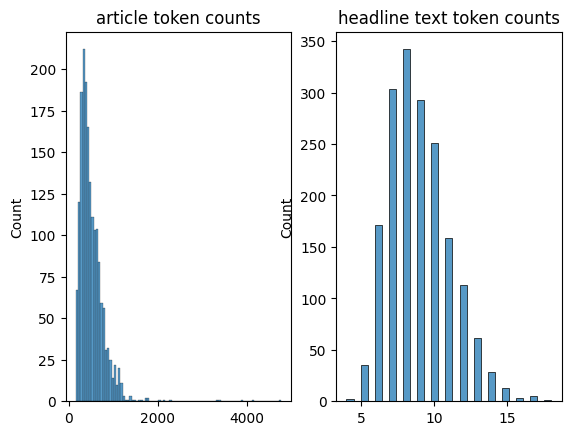

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [9]:
data_module_t5 = NewsHeadlineDataModule(
    train_df,
    val_df,
    test_df,
    tokenizer,
    batch_size=8)

In [15]:
model_t5 = HeadlineGenerationModel("t5-small")

In [11]:
log_path = "logs/t5-small"
checkpoint_path = "checkpoints/t5-small"


checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-t5",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model_t5, data_module_t5)

# BART fine-tuning

In [12]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [13]:
data_module_bart = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [14]:
model_bart = HeadlineGenerationModel("facebook/bart-base")

In [15]:
log_path = 'logs/bart'
checkpoint_path =  'checkpoints/bart'

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-bart",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model_bart, data_module_bart)

# Analysis of the tuned models

In [6]:
trained_t5 = HeadlineGenerationModel.load_from_checkpoint("checkpoints/t5-small/best-checkpoint-t5.ckpt").model.to(device)
pretrained_t5 = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True).to(device)
tokenizer_t5 = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)
trained_bart = BartHeadlineGenerationModel.load_from_checkpoint("checkpoints/bart/best-checkpoint-bart.ckpt").model.to(device)
pretrained_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base", return_dict=True).to(device)
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [18]:
sample_row = data.iloc[7]
text = sample_row["Article"]
hd = sample_row["Headline"]
summary = sample_row['Summary']

print(len(text.split(" ")))
print(f"True headline: {hd}")

317
True headline: India calls for fair trade rules


In [19]:
print(f"Tuned T5: {generate_headline(text, tokenizer_t5, trained_t5, max_new_tokens=20)}")
print(f"Pretrained T5: {generate_headline(text, tokenizer_t5, pretrained_t5, prompt='summarize: ')}\n")

print(f"Tuned Bart: {generate_headline(text, tokenizer_bart, trained_bart, max_new_tokens=20)}")
print(f"Pretrained Bart: {generate_headline(text, tokenizer_bart, pretrained_bart, prompt='')}")

Tuned T5: India 'not cowed' by globalisation
Pretrained T5: india attends the G7 meeting of seven leading industrialised nations on friday. finance minister

Tuned Bart: India to attend G7 meeting
Pretrained Bart: India, which attends the G7 meeting of seven leading industrialised nations on Friday, is


In [8]:
testing_df = data.sample(100).reset_index()

In [9]:
scores_df = calculate_scores_df(testing_df, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=True)

c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bart\modeling_bart.py:587: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


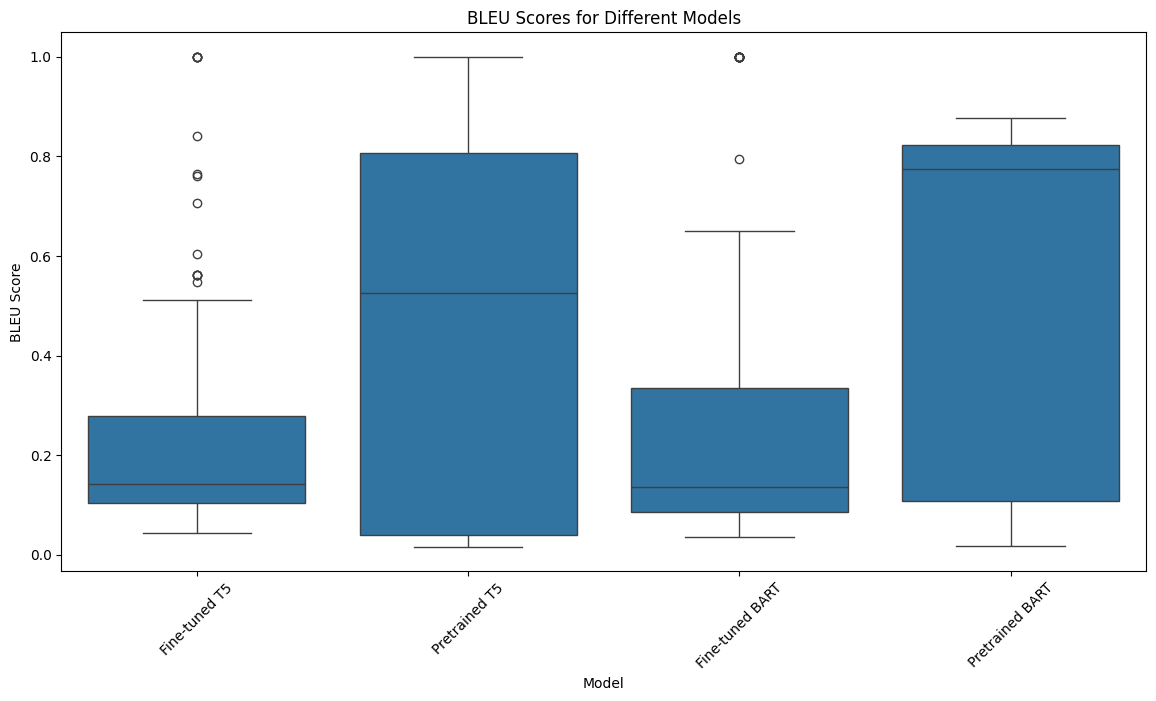

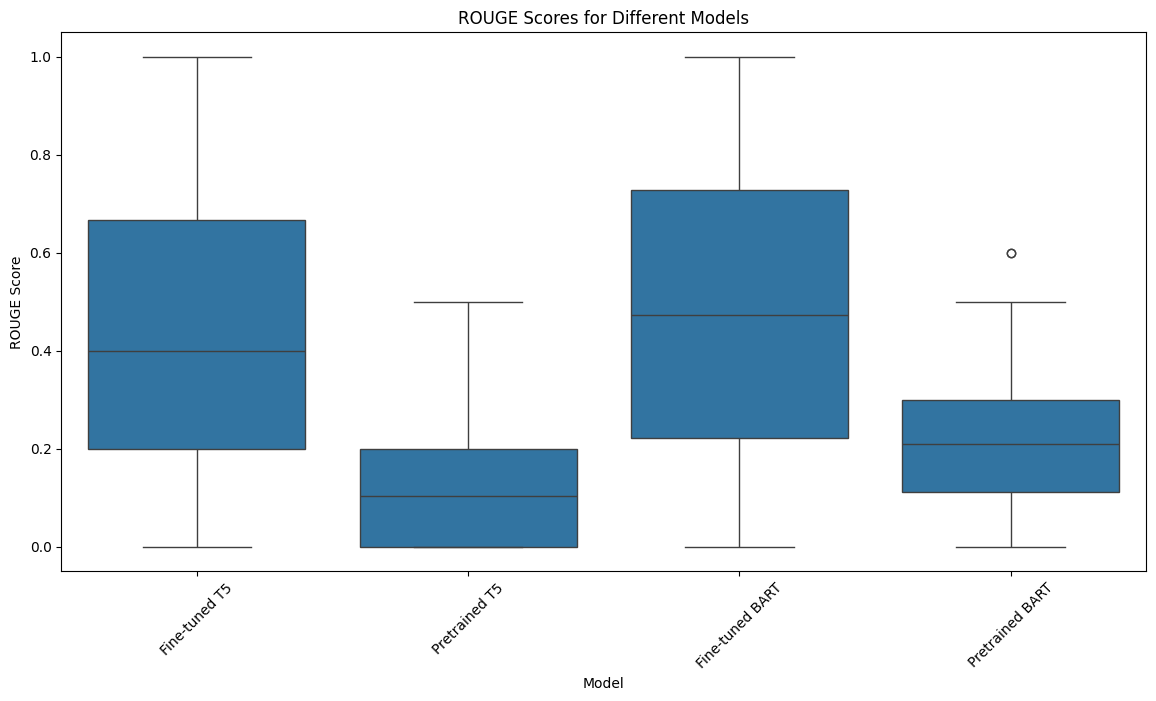

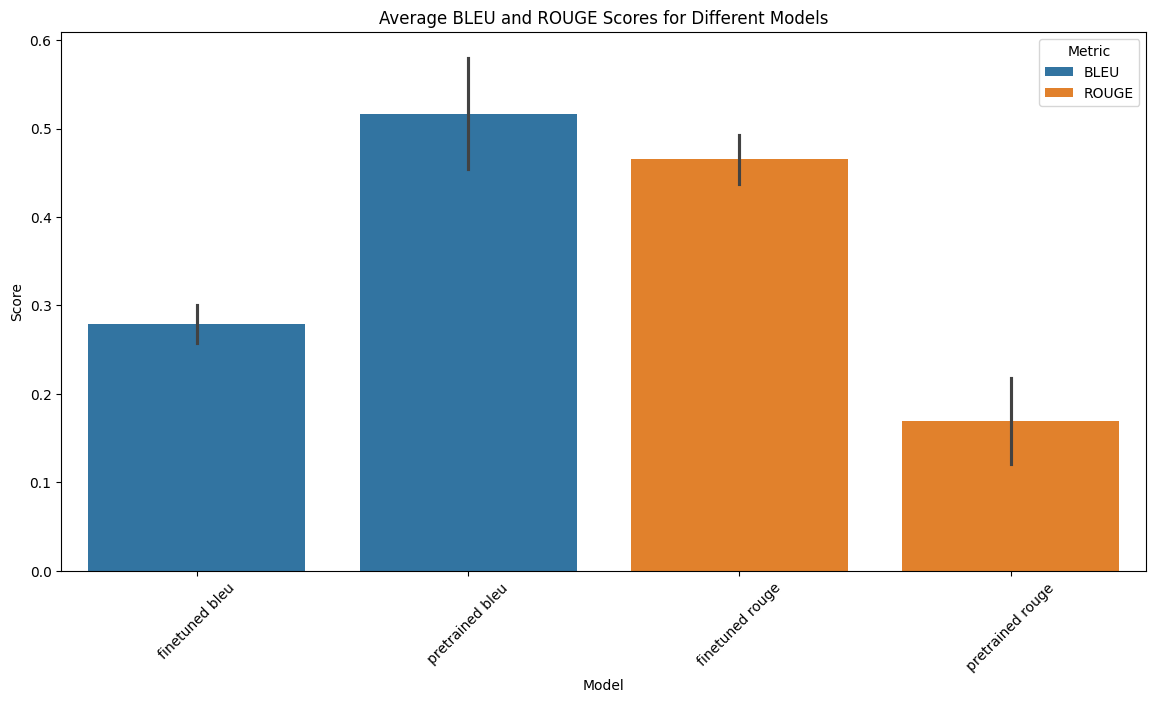

In [11]:
melted_bleu = scores_df.melt(id_vars=['index'], value_vars=['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart'],
                             var_name='Model', value_name='BLEU Score')
melted_rouge = scores_df.melt(id_vars=['index'], value_vars=['rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart'],
                              var_name='Model', value_name='ROUGE Score')

model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_pretrained_t5': 'Pretrained T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'bleu_pretrained_bart': 'Pretrained BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_pretrained_t5': 'Pretrained T5',
    'rouge_finetuned_bart': 'Fine-tuned BART',
    'rouge_pretrained_bart': 'Pretrained BART'
}
melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

avg_scores = scores_df[['bleu_finetuned_t5', 'bleu_pretrained_t5',
                        'bleu_finetuned_bart', 'bleu_pretrained_bart',
                        'rouge_finetuned_t5', 'rouge_pretrained_t5',
                        'rouge_finetuned_bart', 'rouge_pretrained_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()


# Unseen dataset testing

In [21]:
unseen_data = pd.read_csv('data/archive/Articles.csv', encoding='cp1252')
unseen_data = unseen_data[['Article', 'Heading']].sample(100).reset_index().drop(columns=['index']).rename(columns={"Heading": "Headline"})
unseen_data

,Article,Headline
0,Rio de Janeiro: Olympics chief Thomas Bach cal...,IOC chief urges total review of world anti dop...
1,Hong Kong: Most Asia shares rose Wednesday as ...,asian markets mostly recover from hefty sell off
2,strong>SYDNEY: Australian spin great Shane War...,Warne blasts Australia selectors for latest T2...
3,PARIS: The Euro 2016 final on Sunday sees a ma...,France Portugal head for Euro 2016 final showd
4,strong>TOKYO: Tokyo stocks climbed in early tr...,Tokyo stocks rise in early trade on weaker yen...
...,...,...
95,strong>Dutchman Ronald Koeman was named as Eve...,Dutchman Ronald Koeman named as Evertons new m...
96,DHAKA: Virat Kohli’s half-century helped India...,India defeat Sri Lanka by 5 wi
97,strong>ISLAMABAD: The Afghan authorities have ...,Afghan authorities impose cargo charges Pakist...
98,LONDON: British bank HSBC Holdings Plc admitte...,hsbc admits swiss bank failings over client tax


In [ ]:
results_unseen = calculate_scores_df(unseen_data, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=False, verbose=True)

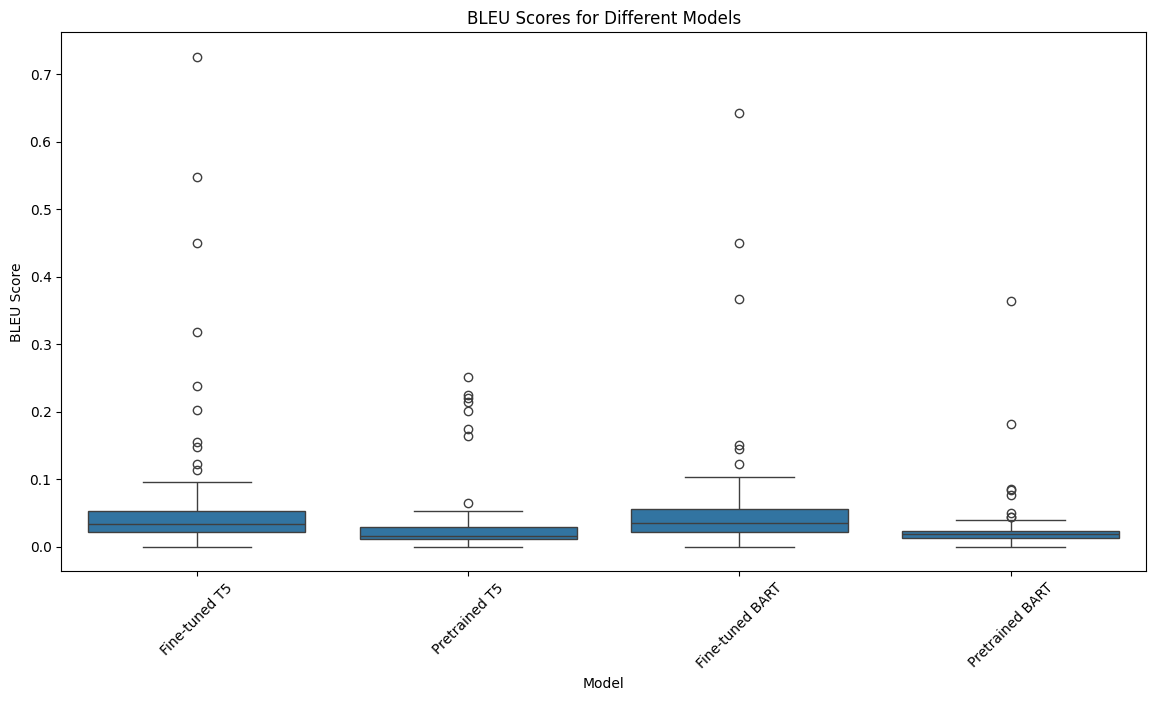

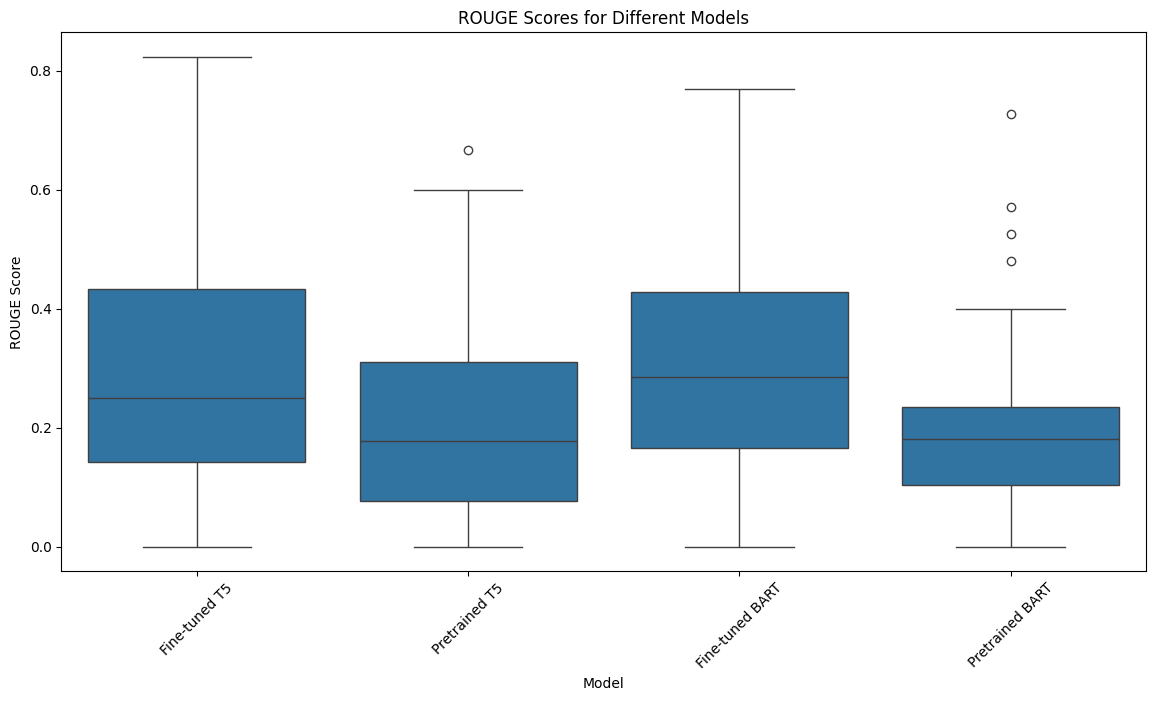

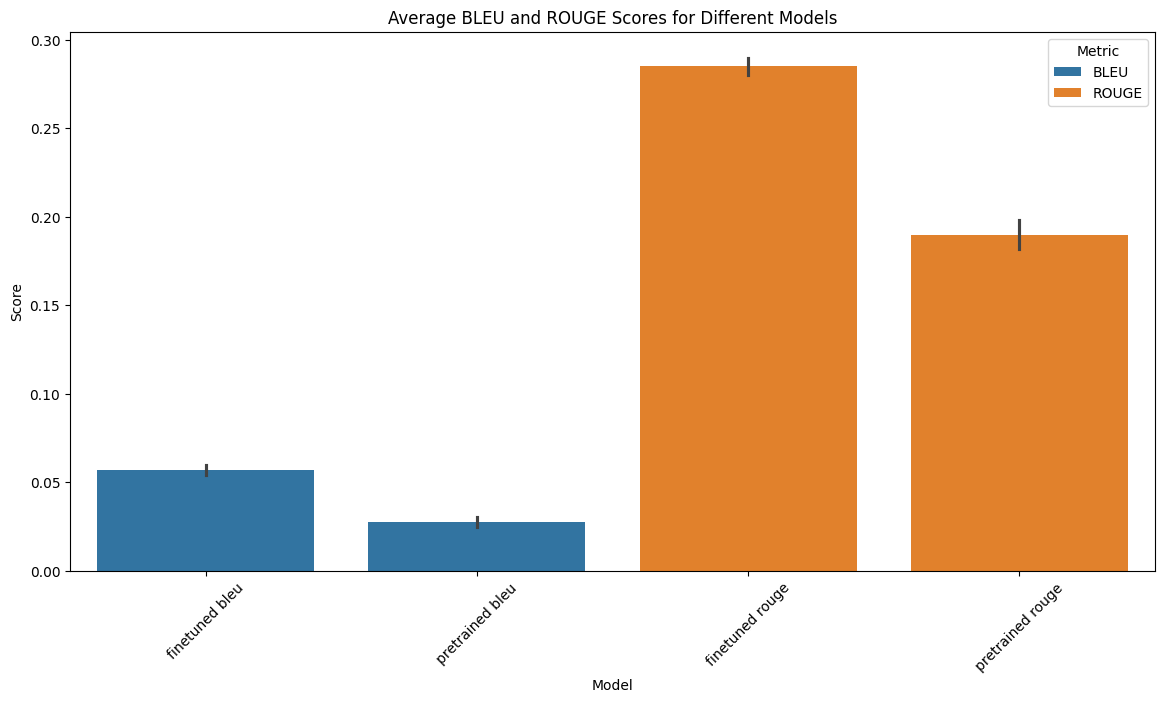

In [15]:
melted_bleu = results_unseen.melt(id_vars=['index'], value_vars=['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart'],
                              var_name='Model', value_name='BLEU Score')
melted_rouge = results_unseen.melt(id_vars=['index'], value_vars=['rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart'],
                               var_name='Model', value_name='ROUGE Score')

model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_pretrained_t5': 'Pretrained T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'bleu_pretrained_bart': 'Pretrained BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_pretrained_t5': 'Pretrained T5',
    'rouge_finetuned_bart': 'Fine-tuned BART',
    'rouge_pretrained_bart': 'Pretrained BART'
}
melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)


plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

avg_scores = results_unseen[['bleu_finetuned_t5', 'bleu_pretrained_t5',
                             'bleu_finetuned_bart', 'bleu_pretrained_bart',
                             'rouge_finetuned_t5', 'rouge_pretrained_t5',
                             'rouge_finetuned_bart', 'rouge_pretrained_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Grammatical correctness

In [30]:
tool = language_tool_python.LanguageTool('en-US')

In [30]:
testing_df

,index,Article,Headline,Summary
0,1929,Some of the most vivid descriptions of the dev...,Web logs aid disaster recovery,Mr Gupta says the power of Morquendi's text me...
1,574,Oscar-winning director Hayao Miyazaki's latest...,Animation charms Japan box office,It has registered the highest opening weekend ...
2,1228,Ex-chat show host Robert Kilroy-Silk is to con...,Kilroy names election seat target,"UKIP's leader, Roger Knapman, has said he is g..."
3,186,A US bank has said it will donate more than $8...,Bank payout to Pinochet victims,A US bank has said it will donate more than $8...
4,569,The film adaptation of Lemony Snicket novels h...,Snicket tops US box office chart,A Series of Unfortunate Events also stars Scot...
...,...,...,...,...
95,1966,Literally putting a face on technology could b...,Putting a face to 'Big Brother',You might even be able to tell your home surve...
96,1827,"Nicholas Negroponte, chairman and founder of M...",Digital guru floats sub-$100 PC,"He said one laptop per child could be "" very i..."
97,2062,The internet could soon have two new domain na...,Go-ahead for new internet names,The internet could soon have two new domain na...
98,1575,Rangers manager Alex McLeish accepts he is goi...,McLeish ready for criticism,McLeish admitted his team's defending was amat...


In [35]:
grammatical_scores = []
for _, row in testing_df.iterrows():
    print(f"Processing row {_}", end='\r')
    hd = row['Headline']
    hd1 = generate_headline(row['Article'], tokenizer_t5, trained_t5, max_new_tokens=20)
    hd2 = generate_headline(row['Article'], tokenizer_t5, pretrained_t5, max_new_tokens=20)
    hd3 = generate_headline(row['Article'], tokenizer_bart, trained_bart, max_new_tokens=20)
    hd4 = generate_headline(row['Article'], tokenizer_bart, pretrained_bart, max_new_tokens=20)
    grammatical_scores.append((row['Headline'], tool.check(hd), tool.check(hd1), tool.check(hd2), tool.check(hd3), tool.check(hd4)))

In [36]:
print(f"Average number of errors in true headlines: {sum([len(x[1]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned T5 headlines: {sum([len(x[2]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in pretrained T5 headlines: {sum([len(x[3]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned BART headlines: {sum([len(x[4]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in pretrained BART headlines: {sum([len(x[5]) for x in grammatical_scores]) / len(grammatical_scores)}")


Average number of errors in true headlines: 0.29
Average number of errors in fine-tuned T5 headlines: 0.37
Average number of errors in pretrained T5 headlines: 1.31
Average number of errors in fine-tuned BART headlines: 0.32
Average number of errors in pretrained BART headlines: 0.46


# Fine-tuned models comparison 

In [27]:
# take example and generate headlines with force words
example = data.iloc[8]
article = example['Article']
headline = example['Headline']

force_words = get_topn_words(article, 2)
print(f"True headline: {headline}")
print(f"Force words: {force_words}")

True headline: Ethiopia's crop production up 24%
Force words: ['food', 'tonnes']


In [28]:
print(f"Tuned T5: {generate_headline(article, tokenizer_t5, trained_t5, max_new_tokens=10, force_words=force_words)}")
print(f"Tuned Bart: {generate_headline(article, tokenizer_bart, trained_bart, max_new_tokens=20, force_words=force_words)}")

print(f"Tuned T5: {generate_headline(article, tokenizer_t5, trained_t5, max_new_tokens=20)}")
print(f"Tuned Bart: {generate_headline(article, tokenizer_bart, trained_bart, max_new_tokens=20)}")

Tuned T5: Ethiopia produces 14.27 million tonnes of food
Tuned Bart: Ethiopia's crop production up 24% in 2004 - FAO reportfoodtonnes
Tuned T5: Ethiopia produces 14.27 million tonnes of crops
Tuned Bart: Ethiopia's crop production surges


In [32]:
grammatical_scores = []
for _, row in testing_df.iterrows():
    print(f"Processing row {_+1}", end='\r')
    force_words = get_topn_words(row['Article'], 2)
    hd = row['Headline']
    hd1 = generate_headline(row['Article'], tokenizer_t5, trained_t5, max_new_tokens=20, force_words=force_words)
    hd2= generate_headline(row['Article'], tokenizer_bart, trained_bart, max_new_tokens=20, force_words=force_words)
    grammatical_scores.append((row['Headline'], tool.check(hd), tool.check(hd1), tool.check(hd2)))

In [34]:
print(f"Average number of errors in true headlines: {sum([len(x[1]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned T5 headlines with force fords: {sum([len(x[2]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned BART headlines with force fords: {sum([len(x[3]) for x in grammatical_scores]) / len(grammatical_scores)}")

Average number of errors in true headlines: 0.22
Average number of errors in fine-tuned T5 headlines with force fords: 1.44
Average number of errors in fine-tuned BART headlines with force fords: 2.24


In [35]:
results_df_tuned = calculate_scores_df_tuned(testing_df, tokenizer_t5, trained_t5, tokenizer_bart, trained_bart, include_summary=False, verbose=True)

In [36]:
results_df_tuned

,index,original_headline,finetuned_t5_headline,finetuned_bart_headline,bleu_finetuned_t5,bleu_finetuned_bart,rouge_finetuned_t5,rouge_finetuned_bart
0,0,Savvy searchers fail to spot ads,Searchers are naive and sophisticated,Savvy searchers fail to spot ads,0.043989,1.000000,0.181818,1.000000
1,1,Bangkok film festival battles on,Bangkok's third film festival continues,Tsunami festival 'to continue',0.095544,0.053728,0.545455,0.222222
2,2,Top gig award for Scissor Sisters,Scissor Sisters wins gig award,V Festival gig wins gig of the year,0.131558,0.027776,0.727273,0.142857
3,3,Apple laptop is 'greatest gadget','Gadget' compiled by mobile magazine,Apple laptop is 'greatest gadget',0.040825,1.000000,0.200000,1.000000
4,4,Sony PSP console hits US in March,PlayStation Portable to go on sale,Sony PSP console heads to Europe,0.000000,0.171033,0.000000,0.461538
...,...,...,...,...,...,...,...,...
95,95,Rap feud in 50 Cent's G-Unit crew,US rapper 'threw Game out of G-Unit',Rapper 50 Cent joins G-Unit feud,0.027776,0.073566,0.235294,0.625000
96,96,Ethiopia's crop production up 24%,Ethiopia produces 14.27 million tonnes of crops,Ethiopia's crop production surges,0.033032,0.448270,0.142857,0.727273
97,97,Three DJs replace Peel radio show,Peel's BBC radio show to be replaced,BBC Radio 1 DJs to take on Peel,0.065006,0.036556,0.428571,0.428571
98,98,Pixies take on Reading and Leeds,"Pixies, Foo Fighters and Iron Maiden top the bill","Pixies, Foo Fighters headline Reading and Leeds",0.025099,0.147722,0.266667,0.615385


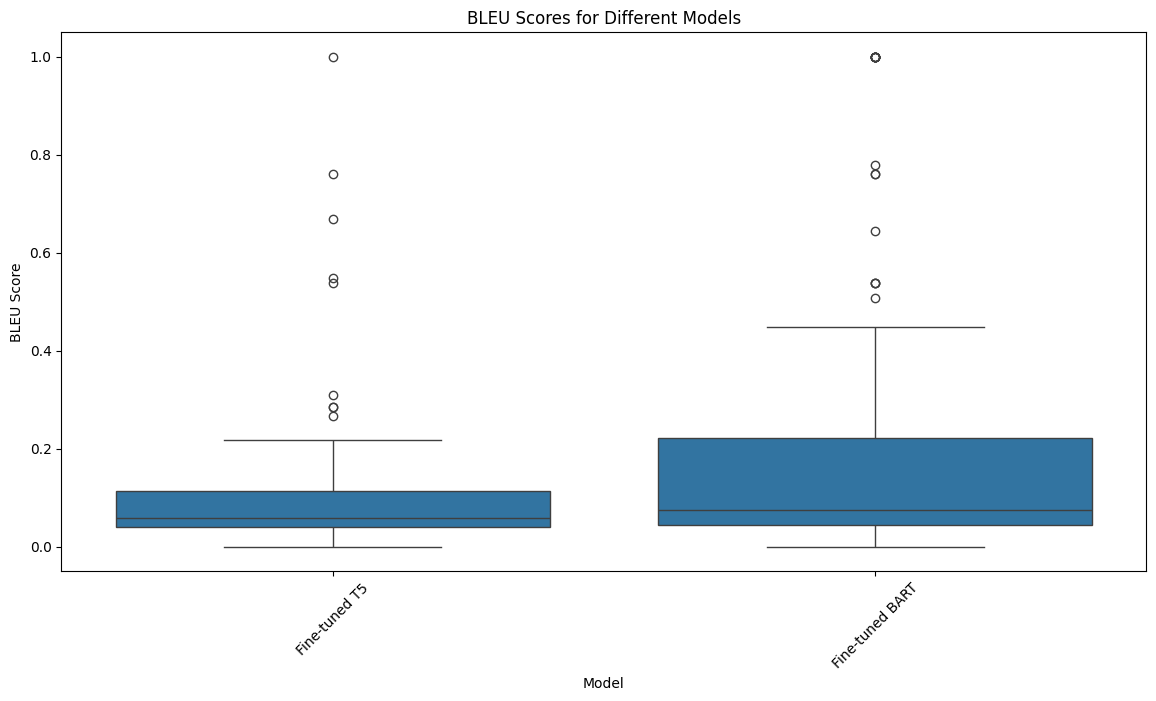

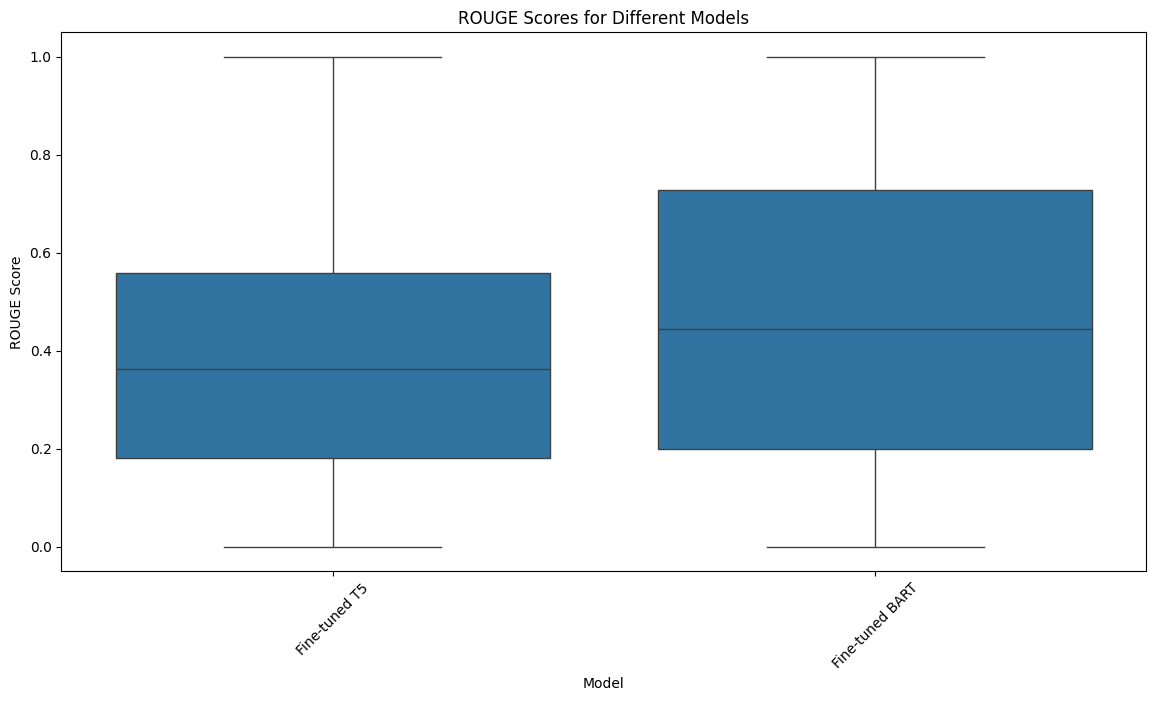

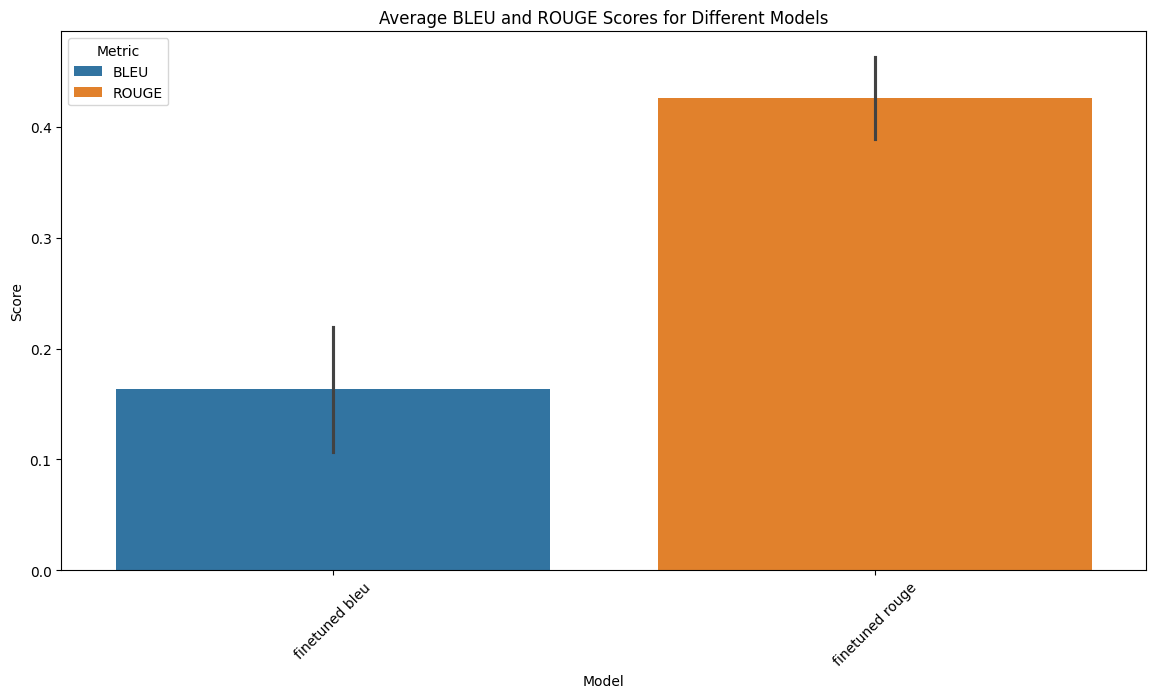

In [37]:

# Melt the DataFrame for BLEU scores
melted_bleu = results_df_tuned.melt(id_vars=['index'], value_vars=[
    'bleu_finetuned_t5', 'bleu_finetuned_bart'],
    var_name='Model', value_name='BLEU Score')

# Melt the DataFrame for ROUGE scores
melted_rouge = results_df_tuned.melt(id_vars=['index'], value_vars=[
    'rouge_finetuned_t5', 'rouge_finetuned_bart'],
    var_name='Model', value_name='ROUGE Score')

# Model mapping for readability
model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_finetuned_bart': 'Fine-tuned BART'
}

melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)

# Plot BLEU Scores
plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot ROUGE Scores
plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Average Scores
avg_scores = results_df_tuned[['bleu_finetuned_t5', 'bleu_finetuned_bart',
                            'rouge_finetuned_t5', 'rouge_finetuned_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

In [38]:
results_df_tuned_unseen = calculate_scores_df_tuned(unseen_data, tokenizer_t5, trained_t5, tokenizer_bart, trained_bart, include_summary=False, verbose=True)

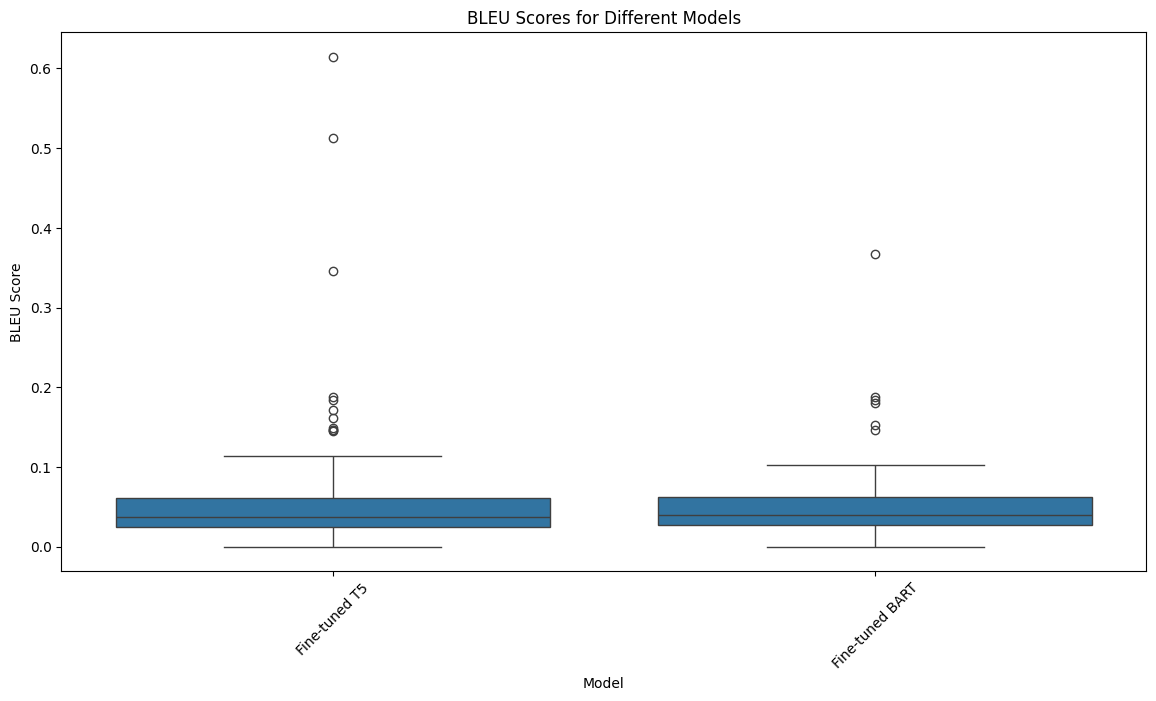

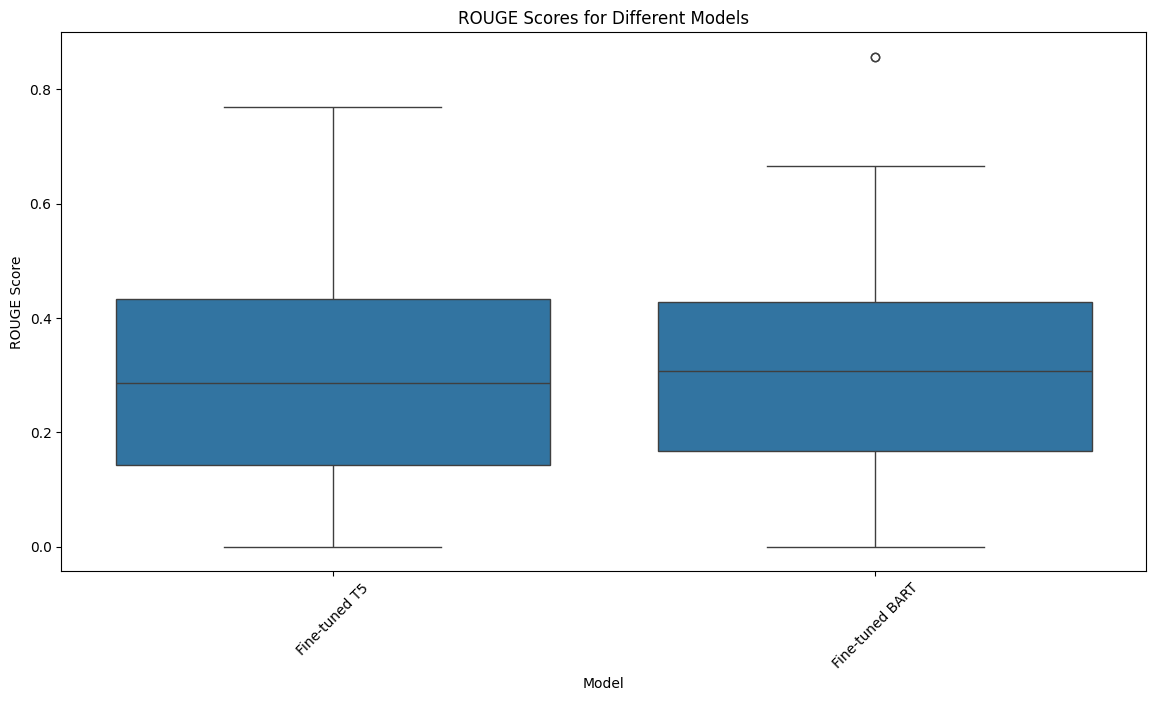

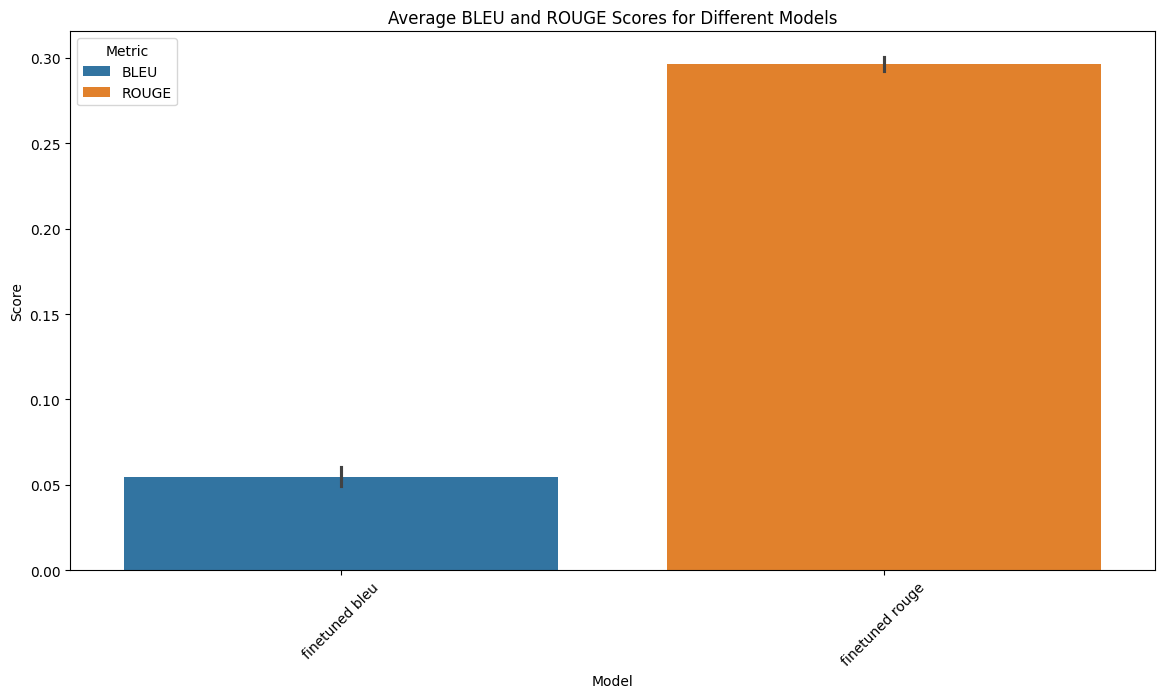

In [40]:

# Melt the DataFrame for BLEU scores
melted_bleu = results_df_tuned_unseen.melt(id_vars=['index'], value_vars=[
    'bleu_finetuned_t5', 'bleu_finetuned_bart'],
    var_name='Model', value_name='BLEU Score')

# Melt the DataFrame for ROUGE scores
melted_rouge = results_df_tuned_unseen.melt(id_vars=['index'], value_vars=[
    'rouge_finetuned_t5', 'rouge_finetuned_bart'],
    var_name='Model', value_name='ROUGE Score')

# Model mapping for readability
model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_finetuned_bart': 'Fine-tuned BART'
}

melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)

# Plot BLEU Scores
plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Plot ROUGE Scores
plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Average Scores
avg_scores = results_df_tuned_unseen[['bleu_finetuned_t5', 'bleu_finetuned_bart',
                            'rouge_finetuned_t5', 'rouge_finetuned_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Perplexity 

In [39]:
t5_headlines = [generate_headline(article, tokenizer_t5, trained_t5, max_new_tokens=20) for article in testing_df['Article']]
bart_headlines = [generate_headline(article, tokenizer_bart, trained_bart, max_new_tokens=20) for article in testing_df['Article']]

In [40]:
perplexity = load("perplexity", module_type="metric")

In [43]:
results_baseline = perplexity.compute(predictions=testing_df["Headline"].to_list(), model_id="gpt2")
results_t5 = perplexity.compute(predictions=t5_headlines, model_id="gpt2")
results_bart = perplexity.compute(predictions=bart_headlines, model_id="gpt2")


print(f"Baseline perplexity: {results_baseline['mean_perplexity']}")
print(f"T5 perplexity: {results_t5['mean_perplexity']}")
print(f"BART perplexity: {results_bart['mean_perplexity']}")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Baseline perplexity: 2235.276198272705
T5 perplexity: 1250.8766836071015
BART perplexity: 1736.2843666648864
